# Loading in the data

In [2]:
#!/usr/bin/env python

import numpy as np
import ase.db
import jax
import jax.numpy as jnp
import functools
import tqdm.auto
import typing
from preprocessing import get_cutoff_mask, get_init_charges, get_gaussian_distance_encodings, v_center_at_atoms_diagonal, type_to_charges_dict, SYMBOL_MAP
from jax import lax, random, numpy as jnp
import optax
import jraph
from typing import Any, Callable, Sequence, Optional


DB_FILE_NAME = "data/SrTiO3_500.db"
# This is the element-to-type map used for generating the descriptors, which
# determines the order of the descriptor vector for each atom.
SORTED_ELEMENTS = sorted(["Sr", "Ti", "O"])
SYMBOL_MAP = {s: i for i, s in enumerate(SORTED_ELEMENTS)}

# 65 Oxygen atoms
# 15 Strontium atoms
# 25 Titanium atoms
type_to_AN_dict = {
    0: 8,
    1: 38,
    2: 22
}

type_to_charges_dict = {
    0: np.float64(-1.15),
    1: np.float64(1.83),
    2: np.float64(1.892)
}

# These labels identify each individual configuration in the larger
# database this small subsample was extracted from.
ind_labels = []
# Atom type, from 0 to n_types - 1.
types = []
# In case we want to use them for the electron-passing NN.
atomic_numbers = []
# Positions of each atom in each configuration, in Cartesian coordinates
# expressed in Å.
positions = []
# There are periodic boundary conditions in effect along the X and Y 
# directions. The length of the simulation box along those directions
# is stored in the elements [0, 0] and [1, 1] of the 3x3 matrices
# stored in this array. Although there is a cell matrix for each
# configuration, they are all the same in this case. The units are also
# Å. The [2, 2] element is immaterial, and the rest are zero.
cell_lengths = []
# Spherical Bessel descriptors for each atom, generated using the following
# parameters:
# N_MAX = 5
# R_CUT = 5.5
descriptors = []
# DDEC6 charges that we will try to predict,
charges = []

cell_size = np.array([])

with ase.db.connect(DB_FILE_NAME) as db:
    for idx, row in enumerate(tqdm.auto.tqdm(db.select(), total=db.count())):
        ind_labels.append(row["ind_label"])
        descriptors.append(row["data"]["bessel_descriptors"])
        charges.append(row["data"]["ddec6_charges"])

        atoms = row.toatoms()
        symbols = atoms.get_chemical_symbols()
        types.append([SYMBOL_MAP[s] for s in symbols])
        atomic_numbers.append(atoms.get_atomic_numbers())
        positions.append(atoms.get_positions())
        cell_lengths.append(atoms.cell.lengths())
        cell_size = atoms.cell

            

# def get_cell_lengths(cell):
#     return jnp.array(cell.lengths())

# v_get_cell_lengths = jnp.vectorize(get_cell_lengths)

descriptors = jnp.asarray(descriptors)
charges = jnp.asarray(charges)
types = jnp.asarray(types)
atomic_numbers = jnp.asarray(atomic_numbers)
positions = jnp.asarray(positions)
# Check if all cell sizes are the same!
# If they are not, we need to use the correct ones for each distance calculation
cell_size = np.array(cell_size)
# Run this as cell size of z-axis is irrelevant
cell_size[2,2]=0.0
cell_size = jnp.array(cell_size)
cell_lengths = jnp.array(cell_lengths)
cell_size

# if np.array([cells[i]==cells[0] for i in range(len(cells))]).flatten().all():
#     cell_size = cells[0]

  0%|          | 0/500 [00:00<?, ?it/s]

DeviceArray([[ 5.5792565,  0.       ,  0.       ],
             [ 0.       , 11.83539  ,  0.       ],
             [ 0.       ,  0.       ,  0.       ]], dtype=float32)

### Cell Size
The cell size is the size of the elemental cell in three dimensions

In [2]:
cell_lengths.shape

(500, 3)

### Bessel descriptors 

The Bessel descriptors describe the dynamics of the system with a 6x21 array for each atom in the slab. The first dimension describes the complete set of possible element-element pairs. The second axis describes angular and radial indices.

Can be treated as black box.

In [52]:
descriptors.shape

(500, 105, 6, 21)

### Charges

The charges are the target values to predict.

In [4]:
charges.shape

(500, 105)

The types describe the elements as categorical integers. The atomic numbers are described by their name. 

In [54]:
types[0]
atomic_numbers[0]
type_to_AN_dict = {
    0: 8,
    1: 38,
    2: 22
}

Positions are 3-dimensional arrays for each atom that describe their position.

In [55]:
positions.shape

(500, 105, 3)

In [56]:
coordinates = positions[0]

# Batch distance calculations with single dimensions

In [67]:
def calculate_xy_distance(v1: jnp.float32, v2: jnp.float32, cell_length: jnp.float32) -> jnp.float32:
    ''' Calculates the the distance of two values over the x- and y-axis with respect to periodic boundary conditions.
    Input:
        - v1: jnp.float32 - x- or y-value of first atom
        - v2: jnp.float32 - x- or y-value of second atom
        - cell_length: jnp.float32 - length of the elemental cell in the respective dimension
    Output:
        - distance in respective dimension
    '''
    delta = v1-v2
    delta = jnp.abs(delta - cell_length*jnp.round(delta/cell_length,0))
    return delta

v_calculate_xy_distance = jnp.vectorize(calculate_xy_distance, excluded = [2])

def calculate_distances(pos1: jnp.array, positions: jnp.array, cell_size: jnp.array):
    ''' Calculates the the distance of two atom-positions in the 3D-space of the slab.
    Input:
        - pos1: jnp.array -> position of first atom
        - pos2: jnp.array -> position of second atom
        - cell_size: jnp.array -> size of elemental cell
    Output:
        - euclidean distance with respect to periodic boundary conditions
    '''
    assert pos1.shape == (3,) and positions.shape == (105,3) and cell_size.shape == (3,)
    x_distances = v_calculate_xy_distance(positions[:,0],pos1[0],cell_size[0])
    y_distances = v_calculate_xy_distance(positions[:,1],pos1[1],cell_size[1])
    z_distances = positions[:,2]-pos1[2]
    euclidean_distances = jnp.sqrt(x_distances**2 + y_distances**2 + z_distances**2)
    return euclidean_distances

@jax.jit
def v_calculate_distances(positions: jnp.array, cell_lengths: jnp.array):
    ''' Calculates the the pairwise distances of all atom-positions in the 3D-space of the slab.
    Input:
        - positions: jnp.array -> positions of all atoms 
        - cell_lengths: jnp.array -> cell lengths repeated to fit batch size
    Output:
        - pairwise euclidean distances with respect to periodic boundary conditions for all atoms in this batch
    '''
    vmapped_func = jax.vmap(calculate_distances)
    positions_rep = jnp.repeat(positions[np.newaxis,:,:],105, axis=0)
    cell_lengths_rep = jnp.repeat(jnp.array(cell_lengths)[jnp.newaxis,:],105, axis=0)
    return vmapped_func(positions,positions_rep,cell_lengths_rep)

@jax.jit
def batch_calculate_distances(batch_positions: jnp.array, batch_cell_lengths: jnp.array):
    ''' Calculates the pairwise distance of atoms in the 3D-space of the slab vectorized for a batch.
    Input:
        - batch_positions: jnp.array -> batch of positions of all atoms 
        - batch_cell_lengths: jnp.array -> batch of cell lengths of second atom
    Output:
        - pairwise euclidean distances with respect to periodic boundary conditions for all atoms in all batches
    '''
    batch_v_calculate_distances = jax.vmap(v_calculate_distances)
    batch_distances = batch_v_calculate_distances(batch_positions, batch_cell_lengths)
    return batch_distances

test_primitive = batch_calculate_distances(positions, cell_lengths)

# Batch distance calculations with jnp.einsum

In [68]:
from functools import partial
@partial(jax.jit, static_argnums=(1,))
def jit_linalg(input, axis):
    return jnp.linalg.norm(input, axis=axis)

@jax.jit
def center_at_atoms(coordinates: jnp.ndarray, cell_size: jnp.ndarray):
    delta = coordinates - coordinates[:, jnp.newaxis, :]
    delta -= jnp.einsum(
        "ijk,kl",
        jnp.round(jnp.einsum("ijk,kl", delta, jnp.linalg.pinv(cell_size))),
        cell_size
    )    
    return jit_linalg(delta,2)

def center_at_atoms_diagonal(coordinates: jnp.ndarray, cell_size_diagonal: jnp.ndarray):
    delta = coordinates - coordinates[:, jnp.newaxis, :]
    zero_indices = cell_size_diagonal == 0.
    icell_size_diagonal = jnp.where(zero_indices, 0., 1. / jnp.where(zero_indices, 1., cell_size_diagonal))
    delta -= cell_size_diagonal * jnp.round(delta * icell_size_diagonal)
    return jnp.sqrt(jnp.sum(delta**2, axis=-1))

v_center_at_atoms_diagonal = jax.jit(jax.vmap(center_at_atoms_diagonal))


# Vectorized version with vmap
v_center_at_atoms = jax.jit(jax.vmap(center_at_atoms))
cell_size_rep = jnp.repeat(jnp.array(cell_size)[jnp.newaxis,:],500, axis=0)
cell_size_diag_rep = jnp.repeat(jnp.diag(cell_size)[jnp.newaxis,:],500, axis=0)
test_einsum = v_center_at_atoms(positions,cell_size_rep)
test_diag_center = v_center_at_atoms_diagonal(positions,jnp.repeat(jnp.diag(cell_size)[jnp.newaxis,:],500, axis=0))

In [59]:
%timeit test_einsum = v_center_at_atoms(positions,cell_size_rep)

9.68 ms ± 79.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
%timeit test_diag_center = v_center_at_atoms_diagonal(positions,cell_size_diag_rep)

136 µs ± 4.69 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [61]:
%timeit test_primitive = batch_calculate_distances(positions, cell_lengths)

142 µs ± 4.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [265]:
print((test_einsum == test_primitive).all())
print((test_diag_center == test_primitive).all())
print((test_einsum == test_diag_center).all())

True
True
True


# Smooth Cutoff

[1. 1. 1. ... 0. 0. 0.]


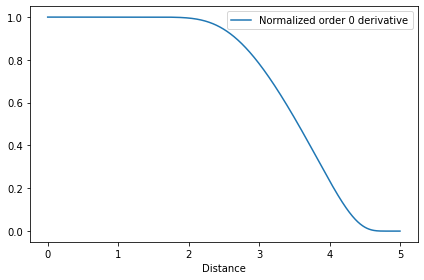

In [71]:
import jax
import jax.numpy as jnp
import functools
import matplotlib
import matplotlib.pyplot as plt

def _aux_function_f(t):
    "First auxiliary function used in the definition of the smooth bump."
    return jnp.where(t > 0., jnp.exp(-1. / jnp.where(t > 0., t, 1.)), 0.)


def _aux_function_g(t):
    "Second auxiliary function used in the definition of the smooth bump."
    f_of_t = _aux_function_f(t)
    return f_of_t / (f_of_t + _aux_function_f(1. - t))


def smooth_cutoff(r, r_switch, r_cut):
    """One-dimensional smooth cutoff function based on a smooth bump.

    This function follows the prescription given by Loring W. Tu in
    "An Introduction to Manifolds", 2nd Edition, Springer

    Args:
        r: The radii at which the function must be evaluated.
        r_switch: The radius at which the function starts differing from 1.
        r_cut: The radius at which the function becomes exactly 0.
    """
    r_switch2 = r_switch * r_switch
    r_cut2 = r_cut * r_cut

    return 1. - _aux_function_g((r * r - r_switch2) / (r_cut2 - r_switch2))





R_SWITCH = 0.5
R_CUT = 5.0
N_DERIVATIVES = 3

test_cutoff = functools.partial(smooth_cutoff,
                                r_switch=R_SWITCH,
                                r_cut=R_CUT)

distance = jnp.linspace(0., R_CUT, num=1001)
to_plot = test_cutoff
for order in range(N_DERIVATIVES + 1):
    samples = jax.jit(jax.vmap(to_plot))(distance)
    print(samples)
    samples /= jnp.fabs(samples).max()
    plt.plot(distance, samples, label=f"Normalized order {order} derivative")
    break
    to_plot = jax.grad(to_plot)

plt.xlabel("Distance")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [272]:
batched_distances = test_diag_center
import importlib
importlib.reload(preprocessing)
x = preprocessing.get_gaussian_distance_encodings(batched_distances)

Mu-Shape (500, 105, 105, 48)
BD-Shape (500, 105, 105, 48)
e-enc shape (500, 105, 105, 48)


# Cutoff from EPNN Github

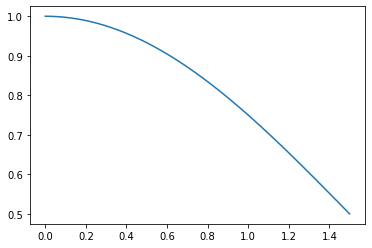

In [275]:
cutoff = 3.0
distance = np.array(distance)
C = (np.cos(np.pi * (distance - 0.0) / cutoff) + 1.0) / 2.0
C[distance >= cutoff] = 0.0
C[distance <= 0.0] = 1.0
plt.plot(distance, C)
plt.show()

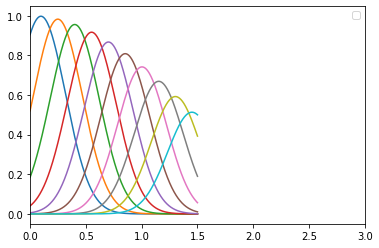

In [286]:
eta= 10
mus = np.linspace(0.1,1.5, 10)
for mu in mus:
    y = C*np.exp(-eta * (distance-mu)**2)
    plt.plot(distance, y)
plt.legend()
plt.xlim((0,3))
plt.show()

# Our cutoff

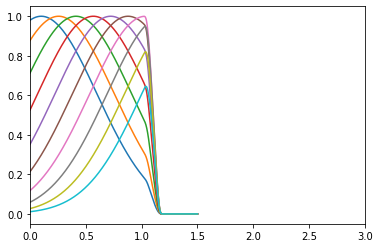

In [264]:
mus = np.linspace(0.1,1.5, 10)
for mu in mus:
    y = jax.jit(jax.vmap(test_cutoff))(distance)*np.exp(-2.0 * (distance-mu)**2)
    plt.plot(distance, y)
plt.xlim((0,3))
plt.show()

In [3]:
import importlib
importlib.reload(preprocessing)
preprocessing.get_init_charges(types,
                                "specific",
                                type_to_charges_dict,
                                jnp.zeros(500))
preprocessing.get_init_charges(types,
                                "average",
                                type_to_charges_dict,
                                jnp.zeros(500))

NameError: name 'preprocessing' is not defined

### Transpose operations as examples

In [306]:
# 2 atoms
A = np.array([
    [1,2,3],
    [4,5,6]
    ])
A = np.tile(np.expand_dims(A,1),(1,2,1))
A

array([[[1, 2, 3],
        [1, 2, 3]],

       [[4, 5, 6],
        [4, 5, 6]]])

In [299]:
A_t = A.transpose(1,0,2)
A_t

array([[[1, 2, 3],
        [4, 5, 6]],

       [[1, 2, 3],
        [4, 5, 6]]])

In [303]:
A_r = np.reshape(A, [-1, A.shape[-1]])
A_t_r = np.reshape(A_t, [-1, A_t.shape[-1]])
print(A_r)
A_t_r

[[1 2 3]
 [1 2 3]
 [4 5 6]
 [4 5 6]]


array([[1, 2, 3],
       [4, 5, 6],
       [1, 2, 3],
       [4, 5, 6]])

In [308]:
np.reshape(A_r, [-1, 2, 2, 3])

(1, 2, 2, 3)

In [3]:
from preprocessing_jraph import get_init_crystal_states


key, subkey = random.split(random.PRNGKey(0))
h_dim = 126
e_dim = 48
layers = [32,32,1] # hidden layers
T = 3
path = "data/SrTiO3_500.db"
n_elems = 3


descriptors, distances_encoded, init_charges, gt_charges, cutoff_mask = get_init_crystal_states(path, edge_encoding_dim = e_dim, SAMPLE_SIZE = None) # Change sample size to None if all samples should be read.

  0%|          | 0/500 [00:00<?, ?it/s]

In [4]:
class MLP_flax(nn.Module):
# TODO: Question: Do we need the output dimension as another feature?=
  features: Sequence[int]
  @nn.compact
  def __call__(self, x, y):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

model = MLP_flax(layers)

In [5]:
x = random.uniform(key, (4,4))
y = random.uniform(key, (4,4))
init_variables = model.init(subkey, x, y=y)
y = model.apply(init_variables, x=x, y=y)


In [43]:
jax.tree_map(lambda x: x.shape, init_variables)

FrozenDict({
    params: {
        Dense_0: {
            bias: (32,),
            kernel: (4, 32),
        },
        Dense_1: {
            bias: (32,),
            kernel: (32, 32),
        },
        Dense_2: {
            bias: (1,),
            kernel: (32, 1),
        },
    },
})

In [6]:
descriptors.shape

(500, 105, 126)

# Testing jraph

In [1]:
from preprocessing_jraph import get_init_crystal_states
# import ase.db
import jax
import typing
# from preprocessing import get_cutoff_mask, get_init_charges, get_gaussian_distance_encodings, v_center_at_atoms_diagonal, type_to_charges_dict, SYMBOL_MAP
from jax import lax, random, numpy as jnp
import optax
import jraph
from typing import Any, Callable, Sequence, Optional, Tuple


key, subkey = random.split(random.PRNGKey(0))
h_dim = 126
e_dim = 48
layers = [32,32,1] # hidden layers
T = 3
path = "data/SrTiO3_500.db"
n_elems = 3
R_SWITCH = 0.5
R_CUT = 3.0


descriptors, distances, distances_encoded, init_charges, gt_charges, cutoff_mask = get_init_crystal_states(path, edge_encoding_dim = e_dim, SAMPLE_SIZE = None, r_switch = 0.5, r_cut = 5.0) # Change sample size to None if all samples should be read.

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
def create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors, distances, distances_encoded, init_charges, cutoff_mask, cutoff = R_CUT):
    batch_size = descriptors.shape[0]
    natom = descriptors.shape[1]
    # Reshaping the descriptors to go over the whole batch
    descriptors = jnp.reshape(descriptors,(batch_size*natom,descriptors.shape[2]))
    
    # to calculate the number of edges for each individual graph
    distances_flattened_batchwise = jnp.reshape(distances,(batch_size,natom*natom))
    n_edges = jnp.count_nonzero(jnp.logical_and(distances_flattened_batchwise > 0, distances_flattened_batchwise < cutoff),axis=1)
    n_nodes = jnp.repeat(jnp.array([natom]),batch_size)
    # Create a flattened index over all previously diagonal elements to be able to delete them from the flattened arrays.
    flatten_idx = jnp.nonzero(jnp.logical_and(distances.flatten() > 0, distances.flatten() < cutoff))[0]
    idx = jnp.nonzero(jnp.logical_and(distances.flatten() > 0, distances.flatten() < cutoff))[0]
    # Make sure that there are only edges between nodes of the same graph
    # Batch range to add onto the tiled outer products
    batch_range = jnp.reshape(jnp.repeat(jnp.arange(batch_size)*natom,natom*natom),(batch_size,natom,natom))
    # outer product over the atoms
    outer = jnp.tile(jnp.outer(jnp.ones(natom),jnp.arange(natom)).astype(jnp.int32),batch_size).reshape(batch_size,natom,natom)
    # transposed for the other variant
    outer_transposed = jnp.transpose(outer, axes=(0,2,1))
    senders = jnp.add(outer_transposed,batch_range).flatten()[flatten_idx]
    receivers = jnp.add(outer,batch_range).flatten()[flatten_idx]
    sender_descriptors = descriptors[senders,:]
    receiver_descriptors = descriptors[senders,:]
    # Encoded distances are also flattened. Combinations of the same node (diagonal) are deleted
    graph_edges = jnp.reshape(distances_encoded,(distances_encoded.shape[0]*distances_encoded.shape[1]*distances_encoded.shape[2],48))[flatten_idx,:]
    # Same for cutoff_mask
    cutoff_mask = cutoff_mask.flatten()[flatten_idx]
    # Nodes contain charges
    # Edges contain concatenation of descriptors, edge_embeddings and cutoff_mask (which will be removed in the Network)
    graph= jraph.GraphsTuple(nodes = init_charges.flatten(),
                            # nodes = jnp.concatenate([descriptors,init_charges],axis=-1), Alternative 
                            senders = senders,
                            receivers = receivers,
                            edges = jnp.concatenate([receiver_descriptors, sender_descriptors, graph_edges, jnp.expand_dims(cutoff_mask,axis=-1)],axis=-1),
                            n_node = n_nodes,
                            n_edge = n_edges,
                            globals = None)
    return graph

size = 50
graph = create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors[:size],distances[:size], distances_encoded[:size],init_charges[:size],cutoff_mask[:size])
graph2 = create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors[size:size*2],distances[size:size*2], distances_encoded[size:size*2],init_charges[size:size*2],cutoff_mask[size:size*2])
# graph = create_implicitly_batched_graphsTuple_with_encoded_distances(descriptors,distances, distances_encoded,init_charges,cutoff_mask)

In [4]:
def print_graph_stats(graph):
    print("Nodes-Shape:",graph[0].shape)
    print("Edges-Shape:",graph[1].shape)
    print("Senders-Length:",graph[2].shape)
    print("Globals:",None if graph[4] is None else graph[4].shape)
    print("n_nodes:",graph[5])
    print("n_edges:",graph[6])

print_graph_stats(graph)

Nodes-Shape: (5250,)
Edges-Shape: (47516, 301)
Senders-Length: (47516,)
Globals: None
n_nodes: [105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105
 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105 105
 105 105 105 105 105 105 105 105 105 105 105 105 105 105]
n_edges: [958 942 926 954 942 950 950 966 974 958 970 934 962 946 942 958 930 958
 954 950 954 958 946 938 986 958 946 942 930 954 930 950 966 974 958 958
 922 962 958 934 934 938 950 966 946 938 926 954 970 946]


In [13]:
import jax.tree_util as tree
import haiku as hk

def aggregate_edges_for_nodes_fn(edges: jnp.array,
                                receivers: jnp.array,
                                cutoff_mask: jnp.array,
                                n_nodes: int) -> jnp.array:
  edges = jnp.multiply(edges,cutoff_mask)
  return jax.ops.segment_sum(edges,receivers,n_nodes)


class MLP_haiku(hk.Module):
  def __init__(self, features: jnp.ndarray):
    super().__init__()
    self.features = features

  def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
    layers = []
    for feat in self.features[:-1]:
      layers.append(hk.Linear(feat))
      layers.append(jax.nn.relu)
    layers.append(hk.Linear(self.features[-1]))
    mlp = hk.Sequential(layers)
    return mlp(x)



# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/_src/models.py#L506
def GraphElectronPassing(aggregate_edges_for_nodes_fn: Callable,
                        MLP: Callable,
                        h_dim: int = 126) -> Callable:
  """
  Args:
    update_node_fn: function used to update the nodes. In the paper a single
      layer MLP is used.
    aggregate_edges_for_nodes_fn: function used to aggregates the sender nodes.

  Returns:
    A method that applies a Graph Convolution layer.
  """

  def _ApplyGEP(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Applies a Graph Convolution layer."""
    nodes, edges, receivers, senders, _, _, _ = graph
    receiver_descriptors = edges[:,:h_dim]
    sender_descriptors=edges[:,h_dim:h_dim*2]
    graph_edges = edges[:,h_dim*2:-1]
    cutoff_mask = jnp.expand_dims(edges[:,-1],axis=-1)
    sender_charges = jnp.expand_dims(nodes[senders],axis=-1)
    receiver_charges = jnp.expand_dims(nodes[receivers],axis=-1)
    # Neural network forward: NN(q_v, q_w, h_v, h_w, e_vw) from the paper
    edges = jnp.concatenate([receiver_charges, sender_charges, receiver_descriptors, sender_descriptors, edges],axis=-1)
    edges_reversed = jnp.concatenate([sender_charges, receiver_charges, sender_descriptors, receiver_descriptors, edges],axis=-1)
    # Subtraction of both outputs to create electron-passing-output for atom v
    MLP_outputs = jnp.subtract(MLP(edges),MLP(edges_reversed))
    # aggregate_edges_for_nodes_fn is the weighting function with the cutoff_mask
    received_attributes = tree.tree_map(
      lambda e: aggregate_edges_for_nodes_fn(e, receivers, cutoff_mask, nodes.shape[0]), MLP_outputs)
    nodes = received_attributes.flatten()
    return graph._replace(nodes=nodes)
  return _ApplyGEP


gep_layer = GraphElectronPassing(
    aggregate_edges_for_nodes_fn=aggregate_edges_for_nodes_fn,
    MLP = lambda n: MLP_haiku(features=[32,32, 1])(n),
)

model = hk.without_apply_rng(hk.transform(gep_layer))
params = model.init(jax.random.PRNGKey(42), graph)
true_labels = gt_charges[:size].flatten()
opt_init, opt_update = optax.adam(1e-2)
opt_state = opt_init(params)

out_graph = model.apply(params,graph)
# out_graph = model.apply(params,out_graph)
# out_graph = model.apply(params,out_graph)


@jax.jit
def rmse_loss(params: hk.Params, graph: jraph.GraphsTuple, num: int = 2) -> jnp.ndarray:
    # hk.fori_loop(0,3, model.apply, graph, params=params)
    output = model.apply(params, graph)
    for i in range(num-1):
      output = model.apply(params, output)
    # output = model.apply(params, output)
    # output = model.apply(params, output)
    return jnp.sqrt(jnp.sum(jnp.square(output[0]-true_labels)/len(true_labels)))

@jax.jit
def update(params: hk.Params, opt_state) -> Tuple[hk.Params, Any]:
    """Returns updated params and state."""
    g = jax.grad(rmse_loss)(params, graph)
    updates, opt_state = opt_update(g, opt_state)
    return optax.apply_updates(params, updates), opt_state

print(rmse_loss(params, graph),rmse_loss(params, graph2)) 
for i in range(1000):
  params, opt_state = update(params, opt_state)
  if (i % 50)==0:
    print(rmse_loss(params, graph),rmse_loss(params, graph2)) 

1.856807 1.8580811
3.8308196 3.8638172
0.09564987 0.10641497
0.0668511 0.096709535
0.055792082 0.09580475
0.069272935 0.11015806
0.0498236 0.095877685
0.048439573 0.098490395
0.042463552 0.09518825
0.04067907 0.09361523
0.038109843 0.09509958
0.04537543 0.09781234
0.042935856 0.09946415
0.036875077 0.0985065
0.032127447 0.095437154
0.033544343 0.098853484
0.04245481 0.090950415
0.031996608 0.10080125
0.030216122 0.097705975
0.03690572 0.10382945
0.028763974 0.097937055


In [2]:
# def create_graphsTuple_with_encoded_distances(descriptors, distances, distances_encoded, init_charges, cutoff_mask, cutoff = R_CUT):
#     natom = descriptors.shape[0]
#     # Create a flattened index over all previously diagonal elements to be able to delete them from the flattened arrays. 
#     flatten_idx = jnp.nonzero(jnp.logical_and(distances > 0, distances < cutoff).flatten())[0]
#     senders = jnp.outer(jnp.ones(natom),jnp.arange(natom)).T.flatten()[flatten_idx].astype(jnp.int32)
#     receivers = jnp.outer(jnp.ones(natom),jnp.arange(natom)).flatten()[flatten_idx].astype(jnp.int32)
#     sender_descriptors = descriptors[senders,:]
#     # print(senders,receivers)
#     receiver_descriptors = descriptors[senders,:]
#     n_nodes = jnp.array([natom])
#     n_edges = jnp.array([natom*natom-natom])
#     # Encoded distances are also flattened. Combinations of the same node (diagonal) are deleted
#     graph_edges = jnp.reshape(distances_encoded,(distances_encoded.shape[0]*distances_encoded.shape[1],48))[flatten_idx,:]
#     # Same for cutoff_mask
#     cutoff_mask = cutoff_mask.flatten()[flatten_idx]
#     # Nodes contain charges
#     # Edges contain concatenation of descriptors, edge_embeddings and cutoff_mask (which will be removed in the Network)
#     graph= jraph.GraphsTuple(nodes = init_charges,
#                             # nodes = jnp.concatenate([descriptors,init_charges],axis=-1), Alternative 
#                             senders = senders,
#                             receivers = receivers,
#                             edges = jnp.concatenate([receiver_descriptors, sender_descriptors, graph_edges, jnp.expand_dims(cutoff_mask,axis=-1)],axis=-1),
#                             n_node = n_nodes,
#                             n_edge = n_edges,
#                             globals = None)
#     return graph

# graph = create_graphsTuple_with_encoded_distances(descriptors[0],distances[0], distances_encoded[0],init_charges[0],cutoff_mask[0])

In [6]:
# natom = 4
# batch_size = 2

# batch_range = jnp.reshape(jnp.repeat(jnp.arange(batch_size)*natom,natom*natom),(batch_size,natom,natom))
# outer = jnp.tile(jnp.outer(jnp.ones(natom),jnp.arange(natom)).astype(jnp.int32),batch_size).reshape(batch_size,natom,natom)
# outer_transposed = jnp.transpose(outer, axes=(0,2,1))
# senders = jnp.add(outer_transposed,batch_range).flatten()
# receivers = jnp.add(outer,batch_range).flatten()

# senders, receivers